In [1]:
#kaggle link for the H&M Personalized Fashion Recommedor
# https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations 


# References for Building the Two Tower Model
# https://www.kaggle.com/code/abhishekmungoli/amazonproductsearch-minidataset-input-embeddings
# https://www.kaggle.com/code/abhishekmungoli/two-tower-retrieval-recommendation-model-training

#https://github.com/amazon-science/esci-data

#YOUTUBE
# https://youtu.be/UhpbTSbi3lI?si=zxn1xtYAFlNN2sGu
# https://youtu.be/o-pZk5R0TZg?si=DedK2cZ7FarU2KJU


<h1>Two Tower Models</h1>

A two-tower model is a deep learning architecture that is used for retrieval tasks, such as search and recommendation.

It consists of two separate towers:
1. Query Tower
2. Product Tower

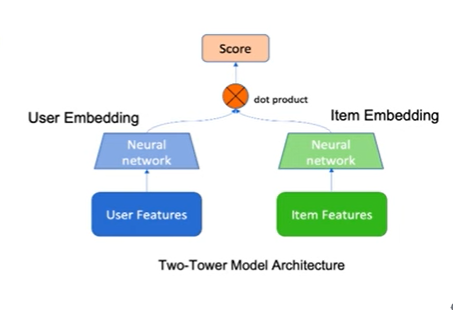

Its successfully used for variety of retrieval tasks in recommendation systems.

-scalable for large datasets
-once trained, it provides embedding of the two entities.

For an <span style="color:green">product-query</span> kind of retrieval system, the product embeddings can be offline calculated and stored and Query embedding can be generated in real-time and an online ANN search can be done on Product's embedding(other-tower) to retrieve top-products.

For a query :

"Nike Foam running shoes women black", how much importance to be given to sgnal like Brand or women, to color or foam shoes

Solution:
using pre-trained embeddings incorporated with other signals like category, price, ratings, review or user-purchase history, purchase pattern user demographic 

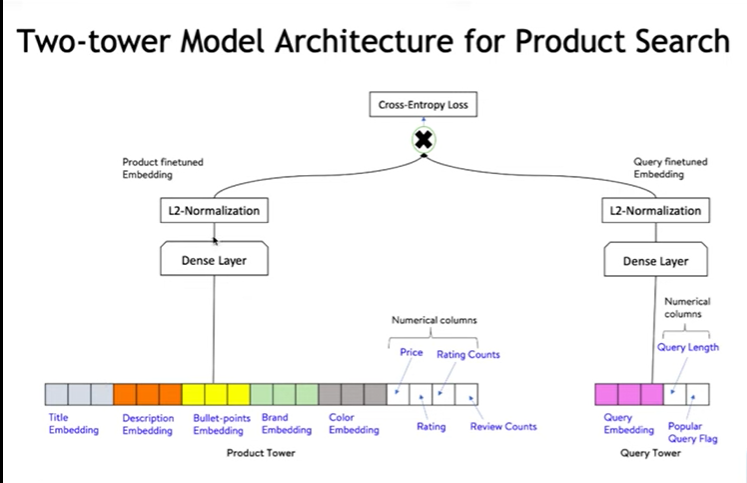

Why L2 normalization?

Normalizing the vector and then doing a DOT product, is representative of the cosine similarity. 

Then doing a Cross-Entropy Loss from the past conversion, if for this query this product converted well or not and fine-tune accordingly(binary-classification problem).

Here, the scenario, we are predicting is purchased or not, we are ranking or predicting interaction scores.

While CEL provides a way to measure prediction errors, it's not the optimal choice for two-tower recommender systems due to computational limitations and the need to consider relative ranking or interaction scores for multiple items. Pairwise and pointwise loss functions are more commonly used due to their better fit for the ranking and interaction prediction tasks in recommender systems.

<h3 style="color:orange">Step-by-Step Breakdown:-</h3>

<h4 style="color:orange">Generating Raw Query Embeddings:</h4>

1. Convert your column into List

2. Generating embeddings using Sentence Transformers
    retreiving chunks of 10000 at a time (orignal dataset has 47000 rows)

3. Reshaping 768D array => 32D array (having 32 columns),
    using reshape.array

4. np.concatenate along columns(axis = 1) these Sentence Embeddings to df_tmp

<span style = "color:green">
        df_tmp = pd.DataFrame(np.concatenate((sentence_embeddings, np.array(sentences).reshape(-1,1)), axis=1))</span>


5. df_tmp.to_csv to query_counter (counter = 0 to 31)

6. Generating 32 files query_0 .... query_31

7. Creating a df dfQCnct where we are concatenating all these files
    <span style = "color:green">    
        file_list = glob.glob('query_*.csv')
        
        for file in file_list:
            df = pd.read_csv(file)
            dfs.append(df)
    </span>



In [1]:
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt

In [2]:
dfArticle = pd.read_csv('/content/articles.csv')
# dfArticle = pd.read_csv('articles.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/articles.csv'

In [69]:
dfArticle.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
dfArticle.shape

(16207, 25)

In [6]:
dfArticle = dfArticle.drop_duplicates(subset=['product_code'])

In [7]:
dfArticle['product_code'].head(20)

0     108775
3     110065
6     111565
8     111586
9     111593
10    111609
11    112679
13    114428
15    116379
16    118458
23    120129
27    123173
28    126589
33    129085
36    130035
37    141661
39    144993
40    145872
46    146706
49    146721
Name: product_code, dtype: int64

In [8]:
dfArticle.shape

(5668, 25)

In [9]:
dfArticle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5668 entries, 0 to 16206
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   article_id                    5668 non-null   int64  
 1   product_code                  5668 non-null   int64  
 2   prod_name                     5668 non-null   object 
 3   product_type_no               5667 non-null   float64
 4   product_type_name             5667 non-null   object 
 5   product_group_name            5667 non-null   object 
 6   graphical_appearance_no       5667 non-null   float64
 7   graphical_appearance_name     5667 non-null   object 
 8   colour_group_code             5667 non-null   float64
 9   colour_group_name             5667 non-null   object 
 10  perceived_colour_value_id     5667 non-null   float64
 11  perceived_colour_value_name   5667 non-null   object 
 12  perceived_colour_master_id    5667 non-null   float64
 13  perceiv

In [10]:
dfArticle.iloc[1]

article_id                                                              110065001
product_code                                                               110065
prod_name                                                       OP T-shirt (Idro)
product_type_no                                                             306.0
product_type_name                                                             Bra
product_group_name                                                      Underwear
graphical_appearance_no                                                 1010016.0
graphical_appearance_name                                                   Solid
colour_group_code                                                             9.0
colour_group_name                                                           Black
perceived_colour_value_id                                                     4.0
perceived_colour_value_name                                                  Dark
perceived_colour

![image.png](attachment:image.png)

BERT

An Encoder stach works bidirectional

uses only the encoder of the transformer
classification token
embedding layer (words => numerical representation)

entering the first encoder layer which is then run through l2 encoder layers and the output is <p style="color:orange">Contextualized Embeddings of the sentence</p>

whereas Word2Vec is a static embedding


![image.png](attachment:image.png)

Each Encoding Layer => Output => 768 dimensional Vector

self-attention mechanism in BERT

Either take the last 4 vectors and concatenate them

Calculating the mean value of 768 dimension vector

BERT was invented for the word vector

last second output is the final output

masking certain words and then finding the embeddings for those words

BERT Model with two heads on top as done during the pre-training:

<span style="color:orange">A masked language modelling head (MLM)</span>

<span style="color:orange">A next sentence prediction head (NSP)</span>


![image.png](attachment:image.png)
<h1></b>SEMANTIC SIMILARITY (cosine similarity) - SBERT</b></h1>

Its a NN class of NN that contains two identical networds (the same configuration, same parameteres and weights).

Parameter updating is mirrored across both networks.

This finds similarity of inputs by comparing its Feature Vectors.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

<h1>Making a Query Column by concatenating words from all the columns against a product</h1>

In [72]:

cols = ['prod_name', 'product_type_name', 'product_group_name',
        'colour_group_name', 'department_name', 'index_name',
        'index_group_name', 'section_name', 'garment_group_name']

def create_query(row):
  # Include product_code in the merging process
   return list(row[cols].astype(str))

dfArticle['query'] = dfArticle.apply(create_query, axis=1)



In [12]:
dfArticle['query'].head(10)

0     [Strap top, Vest top, Garment Upper body, Blac...
3     [OP T-shirt (Idro), Bra, Underwear, Black, Cle...
6     [20 den 1p Stockings, Underwear Tights, Socks ...
8     [Shape Up 30 den 1p Tights, Leggings/Tights, G...
9     [Support 40 den 1p Tights, Underwear Tights, S...
10    [200 den 1p Tights, Underwear Tights, Socks & ...
11    [SWEATSHIRT  OC, Sweater, Garment Upper body, ...
13    [Alice BANDEAU 2-p, Bra, Underwear, White, Cas...
15    [Frugan longsleeve, Top, Garment Upper body, D...
16    [Jerry jogger bottoms, Trousers, Garment Lower...
Name: query, dtype: object

In [70]:
dfArticle.head(1)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


<h1>Dropping columns with nos. for finding Embeddings</h1>

In [73]:
selected_cols = dfArticle[['product_code','prod_name', 'product_type_name', 'product_group_name',
        'colour_group_name', 'department_name', 'index_name',
        'index_group_name', 'section_name', 'garment_group_name','query']]

dfArticle = pd.DataFrame(selected_cols)

dfArticle


,product_code,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,query
0,108775,Strap top,Vest top,Garment Upper body,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top, Vest top, Garment Upper body, Blac..."
1,108775,Strap top,Vest top,Garment Upper body,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top, Vest top, Garment Upper body, Whit..."
2,108775,Strap top (1),Vest top,Garment Upper body,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top (1), Vest top, Garment Upper body, ..."
3,110065,OP T-shirt (Idro),Bra,Underwear,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[OP T-shirt (Idro), Bra, Underwear, Black, Cle..."
4,110065,OP T-shirt (Idro),Bra,Underwear,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[OP T-shirt (Idro), Bra, Underwear, White, Cle..."
...,...,...,...,...,...,...,...,...,...,...,...
105537,953450,5pk regular Placement1,Socks,Socks & Tights,Black,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights,"[5pk regular Placement1, Socks, Socks & Tights..."
105538,953763,SPORT Malaga tank,Vest top,Garment Upper body,Black,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy,"[SPORT Malaga tank, Vest top, Garment Upper bo..."
105539,956217,Cartwheel dress,Dress,Garment Full body,Black,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"[Cartwheel dress, Dress, Garment Full body, Bl..."
105540,957375,CLAIRE HAIR CLAW,Hair clip,Accessories,Black,Small Accessories,Divided,Divided,Divided Accessories,Accessories,"[CLAIRE HAIR CLAW, Hair clip, Accessories, Bla..."


<h2>Dimensionality Reduction: </h2>

Sentence Transformer models often output high-dimensional embeddings (e.g., 768 for BERT). This code could be used to reduce the dimensionality of the embeddings to a smaller value d (defined by the input argument).

 'reshape_array' to condense it to a desired dimension.

This improves transformer efficiency for various downstream tasks like clustering and visualization

Each embedding here is condensed to 'd' dimension

Reshaping and reducing the dimensionality of embeddings.

Any sentence you will give will be converted into 768 dimension embedding.



<h3>1. Splitting each row into d chunks</h3>
<h3>2. Makes a new array with the mean value of its corresponding chunk in the orginal array</h3>

In [15]:
def reshape_array(input_array, d):

    k, _ = input_array.shape
     #k = no. of rows in the input array
     #discarding the no. of columns using _

    new_array = np.zeros((k, d))
    #reshapes the input array with k rows, but with d colums

    for i in range(k):
        for j in range(d):
            #getting the starting index of the chunk size, based on current column(j) and the new dimension(d)
            start_idx = j * (768 // d)

            end_idx = (j + 1) * (768 // d) if j < (d - 1) else 768
            #d-1 ensures all the elments are covered up to 768(assuming orignal array size has 768 columns)
            chunk = input_array[i, start_idx:end_idx]

            new_array[i, j] = np.mean(chunk)

    return new_array

In [16]:
def find_embeddings(lst_product_title,i, maxlen):
    # Define a list of sentences
    sentences = list(lst_product_title)[i:i+step]
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

    return reshape_array(np.array(sentence_embeddings), product_dim)

In [17]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [18]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model
#(you can choose from various models like BERT, RoBERTa, etc.)
model = SentenceTransformer('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when p

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<h1>Understanding how Sentence Transformers work</h1>

In [19]:
# Create sentence embeddings for your sentences,
sentences = ["This is an example sentence.", "Handling unknown words in embeddings is important."]
embeddings = model.encode(sentences, convert_to_tensor=True)
#tensor is nothing but a high dimensional vector

In [20]:
print(embeddings)

tensor([[-0.1690, -0.1832, -0.2340,  ..., -0.1618, -0.3354,  0.4483],
        [-0.0597,  0.2290, -0.3687,  ..., -0.0510, -0.4884,  0.1890]])


In [21]:
# print(len(embeddings[0]))
# reshape_array(np.array(embeddings), 12)

In [22]:
dfArticle['product_code'] = dfArticle['product_code'].fillna('').astype(str)

In [67]:
dfArticle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5667 entries, 0 to 5666
Columns: 107 entries, product_code to q31
dtypes: float64(96), object(11)
memory usage: 4.6+ MB


In [24]:

s_c = dfArticle[['product_code','prod_name', 'product_type_name', 'product_group_name',
        'colour_group_name', 'department_name', 'index_name',
        'index_group_name', 'section_name', 'garment_group_name','query']]


def count_words(text):
    """Calculates the word count for a text string."""
    if pd.notna(text):  # Check if text is not null
        if isinstance(text, str):  # Check if text is a string
            return len(text.split())  # Count words using split() for strings
        else:
            return 0  # Return 0 for non-strings (optional)
    else:
        return 0  # Return 0 for missing values (optional)


In [25]:
# # Calculate medians for each selected column
# median_dict = {}

# for col in s_c:
#     median_dict[col] = dfArticle[col].apply(lambda x: count_words(x)).median()

# # Print medians for each column
# print("Median Word Counts:")
# for col, median in median_dict.items():
#     print(f"\t- {col}: {median}")

CREATING EMBEDDINGS FOR ALL QUERIES

In [77]:
dfArticle['query'] = dfArticle['query'].astype(str)  # Convert to string if necessary
queries = dfArticle['query'].unique().tolist()
print(len(queries))

92215


In [27]:
# #Calculate medians for each selected column
# max_dict = {}
# for col in s_c:
#     max_dict[col] = dfArticle[col].apply(count_words).max()

# # Print medians for each column
# print("Maximum Word Counts:")
# for col, max in max_dict.items():
#     print(f"\t- {col}: {max}")

Converting Query embeddings from 768 => 32

In [28]:
# import numpy as np
# step = 1000
# query_dim = 32

# #Constructing column names headings for query embeddings df as  q0, q1, q2 etc.
# cols = ['q' + str(x) for x in list(range(0, query_dim))] + ['query']

# cnt = 0

# #retrieving a batch of 1000
# for i in range(0,len(queries),step):

#     cnt += 1

#     # Define a list of sentences
#     sentences = list(queries)[i:i+step]

#     #creating sentence embeddings => gives an array 0f 768D
#     sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

#     sentence_embeddings = reshape_array(np.array(sentence_embeddings), query_dim)

#     df_tmp = pd.DataFrame(np.concatenate((sentence_embeddings, np.array(sentences).reshape(-1,1)), axis=1))
#     #Converting the list sentences to a NumPy array and reshaping it.
#     #axis=1: concatenating along columns, placing embeddings in one column and sentences in another.


#     df_tmp.columns = cols

#     df_tmp.to_csv(
#         f'query_{cnt}.csv', header = True, index = False)


#       # f'query_{cnt}.csv': Uses f-strings for dynamic filename creation.
#       # It will be something like query_1.csv where cnt is a variable that likely keeps track of the current query number.

#       # header = True: Includes column names in the CSV file.
#       # index = False: Excludes the row index from the CSV file.

# #     if cnt == 2:
# #         break

#     print(i)

KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()

CREATING EMBEDDINGS OF ALL UNIQUE PRODUCTS

In [78]:
dfArticle.head()

,product_code,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,query
0,108775,Strap top,Vest top,Garment Upper body,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"['Strap top', 'Vest top', 'Garment Upper body'..."
1,108775,Strap top,Vest top,Garment Upper body,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"['Strap top', 'Vest top', 'Garment Upper body'..."
2,108775,Strap top (1),Vest top,Garment Upper body,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"['Strap top (1)', 'Vest top', 'Garment Upper b..."
3,110065,OP T-shirt (Idro),Bra,Underwear,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","['OP T-shirt (Idro)', 'Bra', 'Underwear', 'Bla..."
4,110065,OP T-shirt (Idro),Bra,Underwear,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","['OP T-shirt (Idro)', 'Bra', 'Underwear', 'Whi..."


In [30]:
# lst_product_code = list(str(dfArticle['product_code']))
lst_product_code = list(dfArticle['product_code'])
lst_prod_name = list(dfArticle['prod_name'])
lst_product_type_name = list(dfArticle['product_type_name'])
lst_product_group_name = list(dfArticle['product_group_name'])

lst_colour_group_name = list(dfArticle['colour_group_name'])
lst_department_name = list(dfArticle['department_name'])
lst_index_name = list(dfArticle['index_name'])

lst_index_group_name = list(dfArticle['index_group_name'])
lst_section_name = list(dfArticle['section_name'])
lst_garment_group_name = list(dfArticle['garment_group_name'])


In [31]:
print(len(lst_product_code ),len(lst_prod_name))

5668 5668


In [32]:
results_prod_name = []
results_product_type_name = []
results_product_group_name = []
results_colour_group_name = []
results_department_name = []
results_index_name = []

results_index_group_name = []
results_section_name = []
results_garment_group_name = []

In [33]:
prod_name_max_words = dfArticle['prod_name'].apply(count_words).max()
product_type_name_max_words = dfArticle['product_type_name'].apply(count_words).max()
product_group_name_max_words = dfArticle['product_group_name'].apply(count_words).max()

colour_group_name_max_words = dfArticle['colour_group_name'].apply(count_words).max()
department_name_max_words = dfArticle['department_name'].apply(count_words).max()
index_name_max_words = dfArticle['index_name'].apply(count_words).max()

index_group_name_max_words = dfArticle['index_group_name'].apply(count_words).max()
section_name_max_words = dfArticle['section_name'].apply(count_words).max()
garment_group_name_max_words = dfArticle['garment_group_name'].apply(count_words).max()

In [34]:
print(prod_name_max_words,product_type_name_max_words,product_group_name_max_words)
print(colour_group_name_max_words,department_name_max_words,index_name_max_words)
print(index_group_name_max_words,section_name_max_words,garment_group_name_max_words)

In [48]:
step = 2000
product_dim = 32

#constructing column headings for p+product_code emebddings as p0 + product_code, p1, p2 etc.
cols = ['p' + str(x) for x in list(range(0, product_dim*9))] + ['product_code']\

cnt = 0
for i in range(0,len(lst_prod_name),step):
    cnt += 1

    prod_name_embed = find_embeddings(lst_prod_name, i, prod_name_max_words)
    product_type_name_embed = find_embeddings(lst_product_type_name, i, product_type_name_max_words)
    product_group_name_embed = find_embeddings(lst_product_group_name, i, product_group_name_max_words)

    colour_group_name_embed = find_embeddings(lst_colour_group_name, i, colour_group_name_max_words)
    department_name_embed = find_embeddings(lst_department_name, i, department_name_max_words)
    index_name_embed = find_embeddings(lst_index_name, i, index_name_max_words)

    index_group_name_embed = find_embeddings(lst_index_group_name, i, index_group_name_max_words)
    section_name_embed = find_embeddings(lst_section_name, i, section_name_max_words)
    garment_group_name_embed = find_embeddings(lst_garment_group_name, i, garment_group_name_max_words)

    # Concatenate arrays column-wise and reshape lst_product_code to (x, 1)
    df_tmp = pd.DataFrame(np.concatenate((
           prod_name_embed,
           product_type_name_embed,
           product_group_name_embed,

           colour_group_name_embed,
           department_name_embed,
           index_name_embed,

           index_group_name_embed,
           section_name_embed,
          garment_group_name_embed,


        np.array(lst_product_code[i:i + step]).reshape(-1, 1)
    ), axis=1))


    df_tmp.columns = cols
    df_tmp.to_csv(f'product_{cnt}.csv', header = True, index = False)


#     if (cnt == 2):
#         break
    print(i)

0
2000
4000


In [49]:
import gc
gc.collect()

18

<h1>Making a single file for generated embeddings for different Product Columns</h1>

Storing the raw pre-trained embeddings, which we will eventually fine-tine using the two-tower model.

In [50]:
import pandas as pd
import glob

# Get a list of CSV files that start with "product_"
file_list = glob.glob('product_*.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Read each CSV file and append it to the list
for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
dfPCnct = pd.concat(dfs, ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
dfPCnct.to_csv('product.csv', index=False)


In [51]:
# dfPCnct = dfPCnct.rename(columns={'product_code': 'prod_name'})
print(dfPCnct.shape)

dfPCnct.head()

(5668, 289)


,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p279,p280,p281,p282,p283,p284,p285,p286,p287,product_code
0,-0.013590,-0.063517,-0.026105,0.102011,0.028523,0.029011,0.069749,-0.102603,0.018565,-0.055124,...,0.020720,0.046819,0.023922,0.050316,-0.017086,-0.065530,0.057840,-0.025876,-0.164274,108775
1,0.003132,-0.050609,-0.013409,0.080473,0.029077,0.035610,0.030000,-0.009395,-0.035382,-0.014303,...,-0.031224,0.044536,0.034265,0.047758,-0.008965,0.027491,0.002001,0.005598,-0.132672,110065
2,-0.030804,-0.053186,0.026934,0.070950,-0.016338,0.051843,0.052220,-0.078258,-0.034645,0.029723,...,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111565
3,-0.021453,-0.043523,-0.008224,0.098776,0.005213,0.054952,0.028341,0.005450,-0.024452,0.016790,...,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111586
4,-0.028642,-0.018816,-0.008674,0.102821,-0.022367,0.075419,0.058984,-0.031019,-0.017259,-0.009917,...,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111593


from matplotlib import pyplot as plt
_df_0['p0'].plot(kind='hist', bins=20, title='p0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['p1'].plot(kind='hist', bins=20, title='p1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['p2'].plot(kind='hist', bins=20, title='p2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['p3'].plot(kind='hist', bins=20, title='p3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='p0', y='p1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='p1', y='p2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='p2', y='p3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='p3', y='p4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p5']
  ys = series['p0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('p5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p5')
_ = plt.ylabel('p0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p5']
  ys = series['p1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('p5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p5')
_ = plt.ylabel('p1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p5']
  ys = series['p2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('p5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p5')
_ = plt.ylabel('p2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['p5']
  ys = series['p3']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('p5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('p5')
_ = plt.ylabel('p3')

from matplotlib import pyplot as plt
_df_12['p0'].plot(kind='line', figsize=(8, 4), title='p0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['p1'].plot(kind='line', figsize=(8, 4), title='p1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['p2'].plot(kind='line', figsize=(8, 4), title='p2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['p3'].plot(kind='line', figsize=(8, 4), title='p3')
plt.gca().spines[['top', 'right']].set_visible(False)

In [79]:
dfPCnct=pd.read_csv('product.csv')
dfPCnct.head(1)

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p279,p280,p281,p282,p283,p284,p285,p286,p287,product_code
0,-0.01359,-0.063517,-0.026105,0.102011,0.028523,0.029011,0.069749,-0.102603,0.018565,-0.055124,...,0.02072,0.046819,0.023922,0.050316,-0.017086,-0.06553,0.05784,-0.025876,-0.164274,108775


<h1>Making a single file for generated embeddings for the Query Column</h1>

In [53]:
# import pandas as pd
# import glob

# # Get a list of CSV files that start with "product_"
# file_list = glob.glob('query_*.csv')

# # Initialize an empty list to store DataFrames
# dfs = []

# # Read each CSV file and append it to the list
# for file in file_list:
#     df = pd.read_csv(file)
#     dfs.append(df)

# # Concatenate all DataFrames into one
# dfQCnct = pd.concat(dfs, ignore_index=True)

# # Save the concatenated DataFrame to a new CSV file
# dfQCnct.to_csv('query.csv', index=False)

# print(dfQCnct.shape)

# dfQCnct.head()

In [80]:
dfQCnct=pd.read_csv('query.csv')
dfQCnct.head(1)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q23,q24,q25,q26,q27,q28,q29,q30,q31,query
0,0.114952,-0.016341,-0.046347,0.082836,-0.031131,0.040605,0.026078,0.052963,-0.061668,0.006161,...,-0.020375,0.002625,0.069241,0.08473,0.191488,-0.058067,0.026682,-0.018713,-0.081516,"['NILE set', 'Garment Set', 'Garment Full body..."


Merging the product & queries embeddings to create the final dataset.

In [75]:
dfArticle.head()

,product_code,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,query
0,108775,Strap top,Vest top,Garment Upper body,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top, Vest top, Garment Upper body, Blac..."
1,108775,Strap top,Vest top,Garment Upper body,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top, Vest top, Garment Upper body, Whit..."
2,108775,Strap top (1),Vest top,Garment Upper body,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[Strap top (1), Vest top, Garment Upper body, ..."
3,110065,OP T-shirt (Idro),Bra,Underwear,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[OP T-shirt (Idro), Bra, Underwear, Black, Cle..."
4,110065,OP T-shirt (Idro),Bra,Underwear,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[OP T-shirt (Idro), Bra, Underwear, White, Cle..."


In [57]:
dfArt = pd.read_csv('articles.csv')

In [82]:
dfArticle  = pd.merge(dfArticle, dfQCnct, on = 'query')
# dfArticle.head(1)

dfArticle  = pd.merge(dfArticle, dfPCnct, on = 'product_code')

print(dfArt.shape)

(16207, 313)


In [83]:
dfArticle.columns

Index(['product_code', 'prod_name', 'product_type_name', 'product_group_name',
       'colour_group_name', 'department_name', 'index_name',
       'index_group_name', 'section_name', 'garment_group_name',
       ...
       'p278', 'p279', 'p280', 'p281', 'p282', 'p283', 'p284', 'p285', 'p286',
       'p287'],
      dtype='object', length=363)

In [84]:
dfArticle.head()

,product_code,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,...,p278,p279,p280,p281,p282,p283,p284,p285,p286,p287
0,108775,Strap top,Vest top,Garment Upper body,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,...,-0.039948,0.020720,0.046819,0.023922,0.050316,-0.017086,-0.065530,0.057840,-0.025876,-0.164274
1,110065,OP T-shirt (Idro),Bra,Underwear,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",...,-0.066181,-0.031224,0.044536,0.034265,0.047758,-0.008965,0.027491,0.002001,0.005598,-0.132672
2,111565,20 den 1p Stockings,Underwear Tights,Socks & Tights,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,...,-0.081078,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146
3,111586,Shape Up 30 den 1p Tights,Leggings/Tights,Garment Lower body,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,...,-0.081078,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146
4,111593,Support 40 den 1p Tights,Underwear Tights,Socks & Tights,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,...,-0.081078,-0.043241,-0.003962,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146


In [87]:
dfArticle.iloc[1]

product_code                     110065
prod_name             OP T-shirt (Idro)
product_type_name                   Bra
product_group_name            Underwear
colour_group_name                 Black
                            ...        
p283                          -0.008965
p284                           0.027491
p285                           0.002001
p286                           0.005598
p287                          -0.132672
Name: 1, Length: 363, dtype: object

In [88]:
dfArticle.to_csv('dataset_mini.csv', header = True, index = False)

In [92]:
df_product_embedding = pd.merge(
    pd.read_csv('product.csv'),
    pd.read_csv('dataset_mini.csv')[['product_code','prod_name']],
    on = ['product_code']
).reset_index(drop=True)

df_product_embedding['pid'] = range(0, df_product_embedding.shape[0])

df_query_embedding = pd.read_csv('query.csv')
df_query_embedding['qid'] = range(0, df_query_embedding.shape[0])

In [93]:
df_query_embedding.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q24,q25,q26,q27,q28,q29,q30,q31,query,qid
0,0.114952,-0.016341,-0.046347,0.082836,-0.031131,0.040605,0.026078,0.052963,-0.061668,0.006161,...,0.002625,0.069241,0.084730,0.191488,-0.058067,0.026682,-0.018713,-0.081516,"['NILE set', 'Garment Set', 'Garment Full body...",0
1,0.119459,-0.005948,-0.064375,0.068136,-0.043996,0.033704,0.050884,0.059114,-0.086541,-0.000136,...,-0.032028,0.021322,0.080116,0.221834,-0.047391,0.041180,0.015801,-0.081367,"['Dunshire faux shearling', 'Coat', 'Garment U...",1
2,0.129192,-0.010263,-0.079583,0.065675,-0.048928,0.021886,0.065385,0.085151,-0.086747,0.003730,...,-0.032523,0.048968,0.091159,0.233870,-0.057634,0.051085,0.012937,-0.086411,"['ATLANTIC CHRISTMAS', 'Sweater', 'Garment Upp...",2
3,0.132888,-0.016392,-0.082141,0.020120,-0.033198,0.027618,0.067094,0.053443,-0.098122,0.001565,...,-0.040568,0.029633,0.085255,0.233727,-0.058199,0.044949,0.004975,-0.076863,"['Gemma TRS', 'Trousers', 'Garment Lower body'...",3
4,0.149934,-0.001964,-0.060973,0.041500,-0.049274,0.051105,0.033737,0.027490,-0.087763,-0.006585,...,-0.014905,0.034089,0.086235,0.263106,-0.054122,0.033545,0.007831,-0.085652,"['Class Sally Hoops', 'Earring', 'Accessories'...",4


In [94]:
df_product_embedding.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p281,p282,p283,p284,p285,p286,p287,product_code,prod_name,pid
0,-0.013590,-0.063517,-0.026105,0.102011,0.028523,0.029011,0.069749,-0.102603,0.018565,-0.055124,...,0.023922,0.050316,-0.017086,-0.065530,0.057840,-0.025876,-0.164274,108775,Strap top,0
1,0.003132,-0.050609,-0.013409,0.080473,0.029077,0.035610,0.030000,-0.009395,-0.035382,-0.014303,...,0.034265,0.047758,-0.008965,0.027491,0.002001,0.005598,-0.132672,110065,OP T-shirt (Idro),1
2,-0.030804,-0.053186,0.026934,0.070950,-0.016338,0.051843,0.052220,-0.078258,-0.034645,0.029723,...,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111565,20 den 1p Stockings,2
3,-0.021453,-0.043523,-0.008224,0.098776,0.005213,0.054952,0.028341,0.005450,-0.024452,0.016790,...,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111586,Shape Up 30 den 1p Tights,3
4,-0.028642,-0.018816,-0.008674,0.102821,-0.022367,0.075419,0.058984,-0.031019,-0.017259,-0.009917,...,0.066275,0.093307,0.060168,0.056864,0.065945,-0.015841,-0.161146,111593,Support 40 den 1p Tights,4


In [95]:
print(df_query_embedding.shape, df_product_embedding.shape)

(46349, 34) (6589, 291)


**PERFORMING SANITY CHECK: BY ANN using ANNOY Library**

Why Annoy?


-trades off a small degree of accuracy for significantly faster search time

-It utilizes a tree-based data structure that efficiently navigates high dimensional space.

In [96]:
query_tower_input_dim = 32
product_tower_input_dim = (32*9)

In [97]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552449 sha256=979de33a6cf2a6e783788461f5580b0d7b40d1f31e417f4fd740cd5557e441d5
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [98]:
from annoy import AnnoyIndex

#Creating Annoy Index, which will be used for ANN Search
q = AnnoyIndex(query_tower_input_dim, 'euclidean')

mp_query_dict = {}

for ix,row in df_query_embedding.iterrows():
    mp_query_dict[row['qid']] = row['query']

    key = int(row['qid'])
    vec = list(row[['q'+str(x) for x in list(range(query_tower_input_dim))]])

#     print(key,vec)
    q.add_item(key,vec)

In [ ]:
#likely maps qids with query embeddings
print(mp_query_dict)

In [99]:
q.build(100) # 100 trees
q.save('query.tree')


q = AnnoyIndex(query_tower_input_dim,  'euclidean')
q.load('query.tree')

True

In [100]:
top_k = 20
mat = []
for ix,row in df_query_embedding.iterrows():
    item = row['query']

    #retrieving nearest neighbors for a specific item ID
    #[1:] = slicing the result to exclude the first element(the query itself)
    mat.append([item] + [mp_query_dict[x] for x in q.get_nns_by_item(row['qid'], top_k+1)[1:]])

    #generating for 50 queries
    if ix == 50:
        break

cols = ['query_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors1 = pd.DataFrame(mat, columns = cols)

display(df_neighbors1.head(50)
       )

['query_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,query_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,"['NILE set', 'Garment Set', 'Garment Full body...","['NILE set', 'Garment Set', 'Garment Full body...","['DAVID set', 'Garment Set', 'Garment Full bod...","['TYGA set', 'Garment Set', 'Garment Full body...","['ERIK SET', 'Garment Set', 'Garment Full body...","['PADRON set', 'Garment Set', 'Garment Full bo...","['SNACKS set', 'Garment Set', 'Garment Full bo...","['ELLA set', 'Garment Set', 'Garment Full body...","['RILEY rib set', 'Garment Set', 'Garment Full...","['GRENE rib set', 'Garment Set', 'Garment Full...",...,"['SNACKS LL set', 'Garment Set', 'Garment Full...","['ERIN set', 'Garment Set', 'Garment Full body...","['BIRDIE dress', 'Dress', 'Garment Full body',...","['CORNELIA swim set', 'Garment Set', 'Garment ...","['LOTTA woven dress', 'Dress', 'Garment Full b...","['SEAGULL dress set', 'Dress', 'Garment Full b...","['FILIP set', 'Garment Set', 'Garment Full bod...","['SUKI', 'Garment Set', 'Garment Full body', '...","['STELLAN set', 'Garment Set', 'Garment Full b...","['STELLAN merino set', 'Garment Set', 'Garment..."
1,"['Dunshire faux shearling', 'Coat', 'Garment U...","['Corcscrew fakesuede coat', 'Jacket', 'Garmen...","['Syster Yster wool coat', 'Coat', 'Garment Up...","['Seaworth blazer.', 'Blazer', 'Garment Upper ...","['Snow Chino R.W', 'Trousers', 'Garment Lower ...","['Snow petite chino RW', 'Trousers', 'Garment ...","['COZY FREDDY JOGGER RW', 'Trousers', 'Garment...","['FELIX JOGGER TERRY', 'Trousers', 'Garment Lo...","['Mason pull on RW', 'Trousers', 'Garment Lowe...","['L Sune Shearling Biker', 'Jacket', 'Garment ...",...,"['Ravello shackett', 'Jacket', 'Garment Upper ...","['Lucy wool twill coat', 'Coat', 'Garment Uppe...","['MC Pointer pu.', 'Jacket', 'Garment Upper bo...","['Drape s/s shirt', 'Shirt', 'Garment Upper bo...","['FREDDIE JOGGERS', 'Trousers', 'Garment Lower...","['Vermont fluid essential', 'Trousers', 'Garme...","['LUCAS TROUSER STRAIT', 'Trousers', 'Garment ...","['Nas jogger RW', 'Trousers', 'Garment Lower b...","['Ragdoll fur collar', 'Jacket', 'Garment Uppe...","['MYRA JOGGER', 'Trousers', 'Garment Lower bod..."
2,"['ATLANTIC CHRISTMAS', 'Sweater', 'Garment Upp...","['Pluto sweater', 'Sweater', 'Garment Upper bo...","['Joney sweater', 'Sweater', 'Garment Upper bo...","['cake sweater', 'Sweater', 'Garment Upper bod...","['PORTLAND', 'Sweater', 'Garment Upper body', ...","['Cherie sweater', 'Sweater', 'Garment Upper b...","['Lime sweater', 'Sweater', 'Garment Upper bod...","['Dustin sweater', 'Sweater', 'Garment Upper b...","['Darling sweater', 'Sweater', 'Garment Upper ...","['Slater sweater', 'Sweater', 'Garment Upper b...",...,"['Naturella sweater', 'Sweater', 'Garment Uppe...","['Enrico sweatshirt', 'Sweater', 'Garment Uppe...","['SNAP CREW', 'Sweater', 'Garment Upper body',...","['Randy polo', 'Sweater', 'Garment Upper body'...","['Lilac sweatshirt', 'Sweater', 'Garment Upper...","['Endgame sweater', 'Sweater', 'Garment Upper ...","['PRICE CREW', 'Sweater', 'Garment Upper body'...","['CELINE COZY FRILL', 'Sweater', 'Garment Uppe...","['Nancy', 'T-shirt', 'Garment Upper body', 'Da...","['Dahlia skirt', 'Skirt', 'Garment Lower body'..."
3,"['Gemma TRS', 'Trousers', 'Garment Lower body'...","['Leon TRS', 'Trousers', 'Garment Lower body',...","['Gemma Woven TRS', 'Trousers', 'Garment Lower...","['Pia PU TRS', 'Trousers', 'Garment Lower body...","['Leone TRS', 'Trousers', 'Garment Lower body'...","['Dylan PU', 'Trousers', 'Garment Lower body',...","['Diana Dungaree', 'Trousers', 'Garment Lower ...","['Selena kick flare', 'Trousers', 'Garment Low...","['Stella Pull on TRS', 'Trousers', 'Garment Lo...","['Leon Zip TRS', 'Trousers', 'Garment Lower bo...",...,"['Doreen pullon', 'Trousers', 'Garment Lower b...","['Bowie PU', 'Trousers', 'Garment Lower body',...","['Carly corsett',

**FINDING SIMILAR PRODUCTS**

**<span style="color:orange">Cosine Similarity </span>**

is a measure of the angle between two vectors. A smaller angle indicates greater similarity (closer to 1), and a larger angle indicates less similarity (closer to 0).


**<span style="color:orange">Euclidean Similarity </span>**


It calculates the straight-line distance between two points represented by the vectors. A smaller distance indicates greater similarity (closer to 0), and a larger distance indicates less similarity.

<table style="border: 1px solid #ddd; border-collapse: collapse;">
  <caption>Cosine Similarity vs. Euclidean Similarity</caption>
  <tr style="background-color: #f1f1f1;">
    <th>Feature</th>
    <th>Cosine Similarity</th>
    <th>Euclidean Similarity</th>
  </tr>
  <tr>
    <td>Concept</td>
    <td>Measures the directional similarity between two vectors.</td>
    <td>Measures the straight-line distance between two points in a multidimensional space.</td>
  </tr>
  <tr>
    <td>Focus</td>
    <td>**Direction** of the vectors.</td>
    <td>**Magnitude** (length) of the difference between vectors.</td>
  </tr>
  <tr>
    <td>Sensitivity to Magnitude</td>
    <td>**Insensitive** to the magnitude of vectors.</td>
    <td>**Sensitive** to the magnitude of vectors.</td>
  </tr>
  <tr>
    <td>Normalization</td>
    <td>Often works well with unnormalized data.</td>
    <td>May benefit from normalized data (all vectors having the same magnitude).</td>
  </tr>
  <tr>
    <td>Data Types</td>
    <td>Often used with high-dimensional data (e.g., text embeddings).</td>
    <td>Can be used with any data type.</td>
  </tr>
  <tr>
    <td>Interpretation</td>
    <td>A value closer to 1 indicates higher similarity.</td>
    <td>A value closer to 0 indicates higher similarity.</td>
  </tr>
  <tr>
    <td>Applications</td>
    <td>Text analysis, recommendation systems, document retrieval.</td>
    <td>Image similarity, anomaly detection, k-means clustering.</td>
  </tr>
</table>


In [101]:
p = AnnoyIndex(product_tower_input_dim, 'euclidean')
mp_product_dict = {}

for ix,row in df_product_embedding.iterrows():
    mp_product_dict[int(row['pid'])] = row['prod_name']

    key = int(row['pid'])
    vec = list(row[['p'+str(x) for x in list(range(product_tower_input_dim))]])

#     print(key,vec)
    p.add_item(key,vec)

In [102]:
p.build(100) # 100 trees
p.save('product.tree')

p = AnnoyIndex(product_tower_input_dim,  'euclidean')
p.load('product.tree')

True

In [103]:
len(mp_product_dict.items())

6589

In [105]:
top_k = 20
mat = []
for ix,row in df_product_embedding.iterrows():
    item = row['prod_name']
    mat.append([item] + [mp_product_dict[x] for x in p.get_nns_by_item(row['pid'], top_k+1)[1:]])

    if ix == 50:
        break

cols = ['product_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors2 = pd.DataFrame(mat, columns = cols)

display(df_neighbors2.head(50))

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,Strap top,Halter,V-neck strap top,Beyonce cropped tank,Moa tank,Moa tank,Tent tank top,Lilo lace tank,Johnny,Lizzie.,...,Nora T-shirt,Nora T-shirt,Gilly.,Tindra dress,Tanja dress,Emely Trousers,Jenna dress,Sun dress,Dessie,Inez jumpsuit
1,OP T-shirt (Idro),OP T-shirt. (Idro),SPEED Twiggy paddedsoftbra,Soho cut padding bra,Liza Padded (Idro) 2pk,Liza Padded (Idro) 2pk,Daria strapless Sofia,Lux padded idro,OP Strapless^,Henric Superpush,...,Tilda clean padded bra (1),Tiger padded softbra,Audery padded idro,Valley padded idro,Siana paddad softbra,Tiger padded idro,Clementine Bralette,Rae Softtop Graphic 2p,Rebel soft bralette,Almond padded idro
2,20 den 1p Stockings,200 den 1p Tights,20 den 2p Tights,40 den 2p Tights,40 den 2p Tights,Control Lt 40 den 2p Tights,Push up 70 den 1p Tights,Control Top 200 den 1p Tights,Clean Edge 60 den 1p Leggings,Block 1p Overknee,...,Push Up 30 den 1p Tights,Support 40 den 1p Tights,PLUS Support 70 Den 1 p Tights,Mama Support 70 den 1p Tights,PLUS Support 40 Den 1 p Tights,Mama Small dot 1 p,Box 4p Kneehighs,Mama 100 den 1p Tights,Mama 40 den 2p Tights,Mama 40 den 2p Tights
3,Shape Up 30 den 1p Tights,Highwaist 30 den 1p Tights,Control Top 50 den 1p Tights,Control Top 30 den 1p Tights,Small dot 1p Tights,Fleece 1 p tights,Control Top 100 den 1p Tights,Control Top 100 den 1p Tights,Net 1p Leggings,Mama plain cotton leggings 2p,...,Fake 1p Leggings,Mama 200 den Leggings,Nouvelle 1p Stay Up,Fleece leggings 1 p,Lurex Leggings,Push up 70 den 1p Tights,Push Up 30 den 1p Tights,Mama Support 70 den 1p Tights,Mama 100 den 1p Tights,PLUS Support 40 Den 1 p Tights
4,Support 40 den 1p Tights,Support 70 den 1p Tights,PLUS Support 40 Den 1 p Tights,PLUS Support 70 Den 1 p Tights,Mama Support 70 den 1p Tights,200 den 1p Tights,Push up 70 den 1p Tights,Push Up 30 den 1p Tights,20 den 2p Tights,Lurex 1p Tights,...,40 den 2p Tights,40 den 2p Tights,Control Top 200 den 1p Tights,Clean Edge 60 den 1p Leggings,Support 20 den 1p tights,Heavy plain 2 p tights,Mama 100 den 1p Tights,Heavy Chain 1p Tights,Heavy Chain 1p Tights,Mama 40 den 2p Tights
5,200 den 1p Tights,20 den 2p Tights,40 den 2p Tights,40 den 2p Tights,Push up 70 den 1p Tights,Control Top 200 den 1p Tights,Push Up 30 den 1p Tights,Support 40 den 1p Tights,Mama Support 70 den 1p Tights,Support 70 den 1p Tights,...,PLUS Support 70 Den 1 p Tights,Clean Edge 60 den 1p Leggings,20 den 1p Stockings,Mama 40 den 2p Tights,Mama 40 den 2p Tights,PLUS Support 40 Den 1 p Tights,Lurex 1p Tights,Mama 200 den Tights,Heavy plain 2 p tights,Control Lt 40 den 2p Tights
6,SWEATSHIRT OC,SWEATSHIRT SOLID,SWEATPANTS OC,SWEATPANTS OC,Basic Hood,Dress LS Basic,Dress LS Basic,Basic co/fl cardigan,Basic shorts,Basic bonded jersey sweater,...,BASIC JERSEY TIGHTS OC,Basic sweatshirt with frill,Basic sweatshirt with frill,Basic Loose Jerseypants,Basic bonded jersey trousers,Basic bonded jersey trousers,Basic Henley body,Basic Henley body,Dress LS Velour w Collar,Basic hood sweater
7,Alice BANDEAU 2-p,Alice Lace Bandeau 2p,Kelly (Melbourne) PUSH 2p,Liza Push Melbourne 2pk,Liza Push Melbourne 2pk,Rae Padded (Idro) 2p,Ida Padded bra (1),Kelly Lace Padded Idro 2p,Gigi SP Andes,Frenchy Bandeau 2p,...,Alma Push (Melbourne) 2pk,Marigold SP Andes^,Marigold SP Andes^,Clementine Bralette,Prince softbra V.5,50 cent balconette sofia,Liza Padded (Idro) 2pk,Liza Padded (Idro) 2pk,Leila padded BIG,Stetson SP Andes
8,Frugan longsleeve,Nanni,Sigita,Sigita,Fia longsleeve (1),Kory,Ezzi,Alana dress,Flora playsuit,Tindra dress,...,Helsinki,Bobo Trousers,Wilma,Ronja t-shirt,Ziggy Linnen LS,Mapei,Titti,Nathalie tank,Bee top,Tanja dress
9,Jerry jogger bottoms,Jerry jogger bottoms,Benny Shorts (1),WREN SWEATPANTS,WREN SWEATPANTS,VINCENT SWEATPANTS,Sigge shorts,ROLAND HOOD,PETER SLIM FIT POLO,PET

In [ ]:
#line18